# imports

In [1]:
% load_ext autoreload
% autoreload 2


In [2]:
import glob
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import datetime
import src.mex_helper as mex
import folium
from src.utils.map_vis import time_slider_choropleth, geojson_per_row

In [3]:
from scipy import stats


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import src.utils.gis as gis
from src.features import *

# grid average

In [6]:
def grid_avgerage(tw_avg, t2g):
    # there are grids without any call throughout the observation period
    g_avg = t2g.merge(tw_avg, left_on='gtid', right_index=True, how='left')

    for h in range(24):
        h = str(h)
        g_avg[h] = g_avg[h] * g_avg['weight']

    g_avg = g_avg.drop(['gtid', 'weight'],
                       axis=1).groupby('grid').sum()  # fillna=0 by default

    return g_avg

In [7]:
aver = mex.stat_tw_dow_aver_hr_uniq_user('out+in')
tw_avg_wd = pd.DataFrame(aver['wd']).T
tw_avg_wk = pd.DataFrame(aver['wk']).T

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle


In [8]:
gsides = [500, 1000, 2000]
n_regions = 16
htypes = ['average', 'loubar']

In [9]:
rkind = 'metropolitans_16'
rname = 'metropolitan'

In [10]:
mex_mpol = mex.metropolitans_16()

In [11]:
mex_t2g_mpol = {}
g_avg_wd_mpol={}
g_avg_wk_mpol={}
for gside in gsides:
    t2g = mex.tower2grid(rkind, gside)
    print(
    'number of towers in cities has no call at all during weekday and weekend',
    len(set(t2g.gtid) - set(tw_avg_wd.index)),
    len(set(t2g.gtid) - set(tw_avg_wk.index)))
    avg_wd = grid_avgerage(tw_avg_wd, t2g)
    avg_wk = grid_avgerage(tw_avg_wk, t2g)
    mex_t2g_mpol[gside] = t2g
    g_avg_wd_mpol[gside] = avg_wd
    g_avg_wk_mpol[gside] = avg_wk

reading existing t2g file: data/mex_tower/mex_t2g_metropolitans_16_500m.csv
number of towers in cities has no call at all during weekday and weekend 233 234
reading existing t2g file: data/mex_tower/mex_t2g_metropolitans_16_1000m.csv
number of towers in cities has no call at all during weekday and weekend 233 234
reading existing t2g file: data/mex_tower/mex_t2g_metropolitans_16_2000m.csv
number of towers in cities has no call at all during weekday and weekend 233 234


In [12]:

dv_r_mpol = {}
for gside in gsides:
    if gside==500:
        continue
    avg_wd = g_avg_wd_mpol[gside]
    dv_wd = urban_dilatation_index(avg_wd, rkind, rname, gside)    
    dv_r_mpol[gside] = dv_wd

reading existing grids
reading existing grids


# dilation coefficient is similar

In [13]:
import plotly.offline as offline
offline.init_notebook_mode(connected=True)

In [14]:
tmp = dv_r_mpol[1000].drop('dilatation coefficient', axis=1)
offline.iplot({
    'data':[{'x': list(range(24)), 'y': tmp.loc[r].tolist(), 'name': r} for r in tmp.index]
})

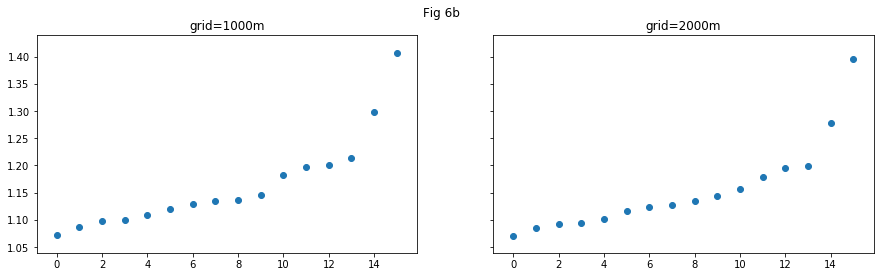

In [15]:
fig, axes = plt.subplots(1, len(gsides[1:]), sharex=True, sharey=True, figsize=(15,4))
fig.suptitle('Fig 6b')
dc_order = []
for i, gside in enumerate(gsides[1:]):
    dv_wd = dv_r_mpol[gside]
    dv_wd_sort = dv_wd.sort_values('dilatation coefficient')
    dv_wd_sort[f'{gside}m'] = range(n_regions)
    axes[i].scatter(
        range(n_regions),
        dv_wd_sort['dilatation coefficient'].values)
    dc_order.append(dv_wd_sort[f'{gside}m'])
    axes[i].set_title(f'grid={gside}m')

In [16]:
pd.concat(dc_order, axis=1, sort=False)

,1000m,2000m
"Monterrey, Nuevo León",0,0
"Tijuana, Baja California",1,1
"Cancún, Quintana Roo",2,2
"Cuernavaca, Morelos",3,3
"Acapulco de Juárez, Guerrero",4,4
"Valle de Mexico, Distrito Federal",5,5
"Guadalajara, Jalisco",6,7
"Toluca de Lerdo, México",7,6
"Nuevo Laredo, Tamaulipas",8,8
"Juárez, Chihuahua",9,9


# hotspot analysis

In [23]:
n_hotspot_mpol={}
hotspot_stats_mpol={}
permanent_regions_mpol = {}
persistence_mpol = {}

for gside in gsides:
    for hotspot_type in htypes:
        print(gside, hotspot_type)
        n_hotspot_hourly, h_stats, permanent_regions, persistence=  hotspot_stats(g_avg_wd_mpol[gside],rkind,rname,gside, hotspot_type)
        n_hotspot_mpol[(gside, hotspot_type)]=n_hotspot_hourly
        hotspot_stats_mpol[(gside, hotspot_type)]=h_stats
        permanent_regions_mpol[(gside, hotspot_type)]= permanent_regions
        persistence_mpol[(gside, hotspot_type)] = persistence

500 average
reading existing grids
500 loubar
reading existing grids
1000 average
reading existing grids
1000 loubar
reading existing grids
2000 average
reading existing grids
2000 loubar
reading existing grids


## Time evolution of Number of Hotspot (somewhat duplicating the Fig 13)

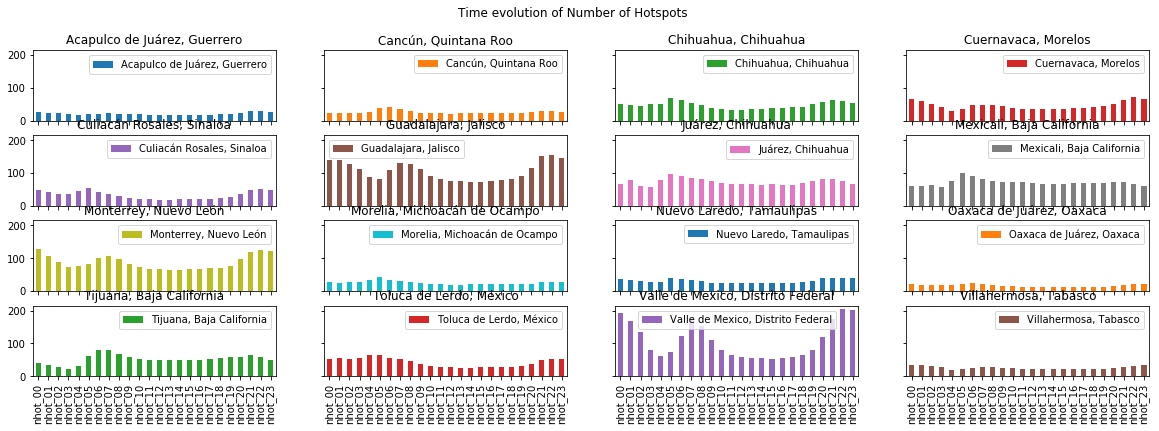

In [24]:
pd.DataFrame(n_hotspot_mpol[(1000,'loubar')]).T.plot(
    kind='bar',figsize=(20,6),subplots=True, layout=(4,4),sharey=True, title='Time evolution of Number of Hotspots')
print()

## Fig 8 Hotspot duration distribution

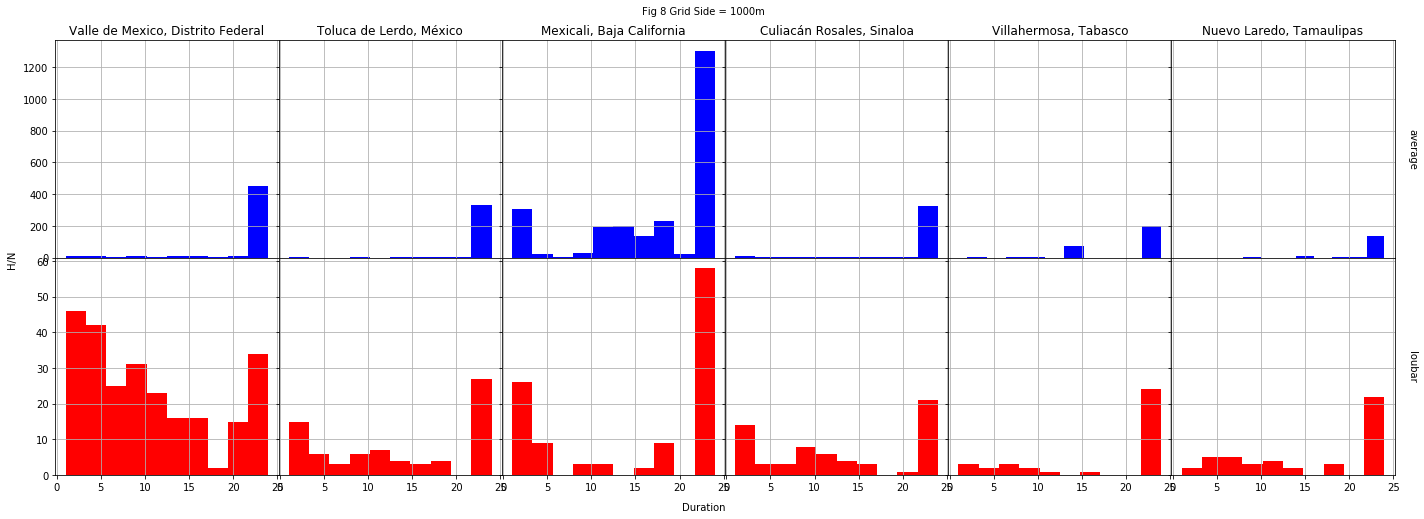

In [27]:
nth_populated_regions = [0, 3, 6, 9, 12, 15]

n_rows = len(htypes)
n_cols = len(nth_populated_regions)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey='row')

fig.text(0.5, .93, 'Fig 8 Grid Side = 1000m', ha='center', va='center')
fig.text(0.5, 0.07, 'Duration', ha='center', va='center')
fig.text(0.1, 0.5, 'H/N', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0, wspace=0)

for i, htype in enumerate(htypes):
    color = {'loubar': 'red', 'average': 'blue'}[htype]
    persistence = persistence_mpol[(1000, htype)]
    for j, r in enumerate(mex_mpol.index[nth_populated_regions]):
        ax = axes[i,j]
        persistence[r][persistence[r]!=0].hist(ax=ax, color=color)

        if i==0:
            ax.set_title(r)
                
for i, htype in enumerate(htypes):
    ax = axes[i,n_cols-1]
    ax.text(ax.get_xlim()[1]+2, ax.get_ylim()[1]*0.5, htype, ha='center', va='center', rotation=270)

## Fig 13 H/N

In [28]:
n_grids ={gside:mex.grids(rkind, gside).groupby(rname).size() for gside in gsides}

reading existing grids
reading existing grids
reading existing grids


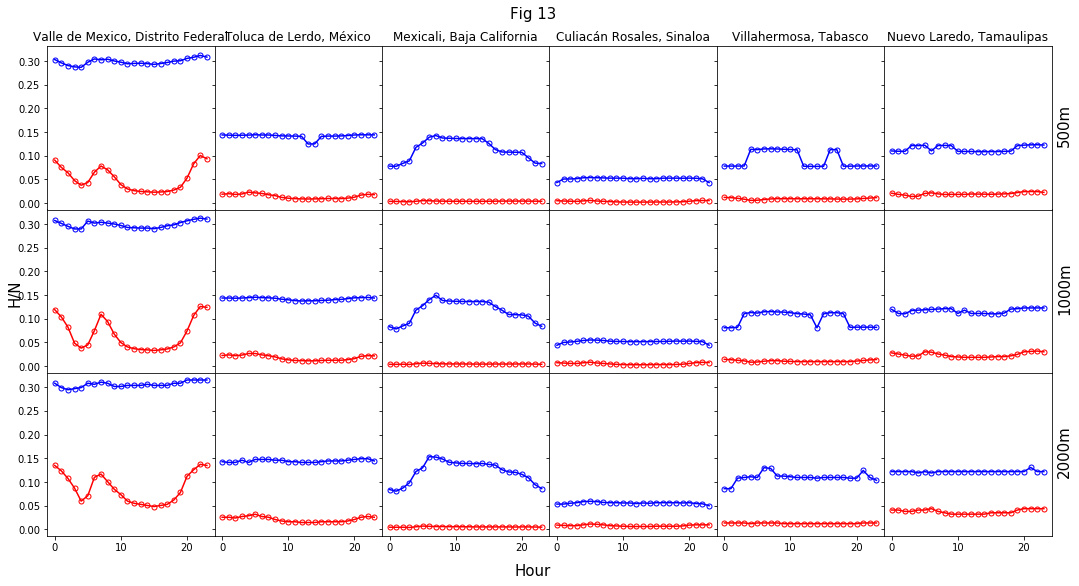

In [42]:
nth_populated_regions = [0,3,6,9,12,15]

n_rows = len(gsides)
n_cols = len(nth_populated_regions)

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(3*n_cols, 3*n_rows), sharex=True, sharey=True)

fig.text(0.5, .93, 'Fig 13', ha='center', va='center', fontsize=15)
fig.text(0.5, 0.07, 'Hour', ha='center', va='center', fontsize=15)
fig.text(0.1, 0.5, 'H/N', ha='center', va='center', rotation='vertical', fontsize=15)
fig.subplots_adjust(hspace=0,wspace=0)

for i, gside in enumerate(gsides):
    for htype in ['loubar', 'average']:
        color = {'loubar': 'red', 'average': 'blue'}[htype]
        h_by_n = n_hotspot_mpol[(gside,htype)].divide(n_grids[gside],axis='rows')
        for j, r in enumerate(mex_mpol.index[nth_populated_regions]):
            ax = axes[i,j]

            ax.plot(range(24), h_by_n.loc[r], 'o-', color=color, markerfacecolor='None', markersize=5)
            if i==0:
                ax.set_title(r)
                
for i, gside in enumerate(gsides):
    ax = axes[i,n_cols-1]
    ax.text(ax.get_xlim()[1]+2, ax.get_ylim()[1]*0.5, f'{gside}m', ha='center', va='center', rotation='vertical', fontsize=15)

## Fig7 and 14  average_hotspot vs population

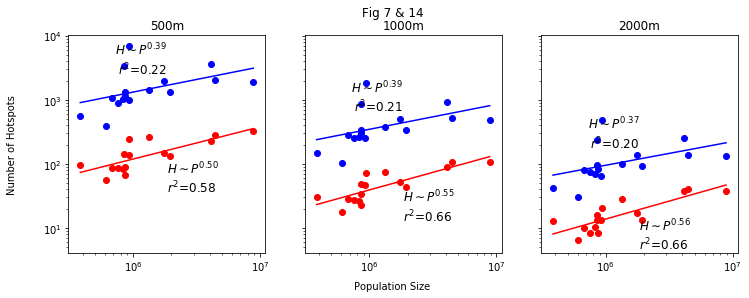

In [30]:
fig, axes = plt.subplots(1, len(gsides), figsize=(12, 4), sharex=True, sharey=True)

fig.suptitle('Fig 7 & 14')
fig.text(0.5, 0.01, 'Population Size', ha='center', va='center')
fig.text(0.06, 0.5, 'Number of Hotspots', ha='center', va='center', rotation='vertical')
# fig.text(1,0.9, r'$H \sim P^{0.6}$')
# fig.text(1, 0.8, r'$r^2 \equal 10$')
for i, gside in enumerate(gsides):
    for hotspot_type in ['loubar', 'average']:
        color = {'loubar': 'red', 'average': 'blue'}[hotspot_type]
        
        x = mex_mpol.population.sort_index()
        y = n_hotspot_mpol[(gside, hotspot_type)].mean(axis=1).sort_index()
        axes[i].scatter(x=x, y=y, color=color)
        axes[i].set_xscale("log")
        axes[i].set_yscale("log")
        
        log_x = np.log(x)
        log_y = np.log(y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x,log_y)
        min_max_x = np.array([x.min(), x.max()])
        min_max_y_fit = np.exp(slope * np.log(min_max_x) + intercept)
        log_scale_mean_x = np.exp(np.log(min_max_x).mean())
        axes[i].plot(min_max_x,min_max_y_fit, color=color)
        axes[i].set_title(f'{gside}m')
        if hotspot_type =='average':
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()*2.5, r'$H \sim P^{%.02f}$' % slope, ha='right', fontsize=12)
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()*1.25, r'$r^2 \equal {%.02f}$' % r_value**2, ha='right', fontsize=12)            
        if hotspot_type =='loubar':
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()/3, r'$H \sim P^{%.02f}$' % slope, ha='left', fontsize=12)
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()/6, r'$r^2 \equal {%.02f}$' % r_value**2, ha='left', fontsize=12)            

## Fig 9a Compacity Coef. 

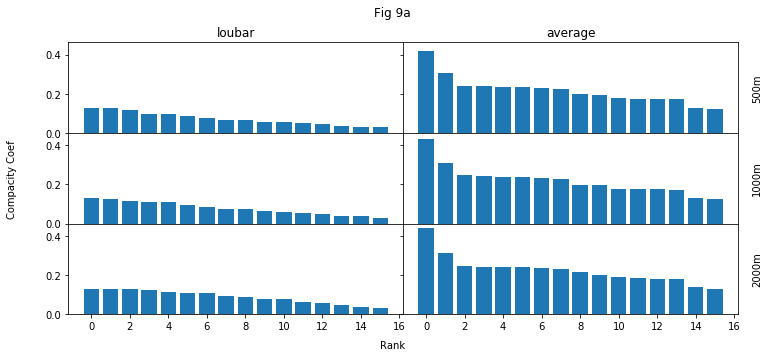

In [31]:
fig, axes = plt.subplots(len(gsides), 2, sharex=True, sharey=True, figsize=(12,5))
cc_order = []
fig.suptitle('Fig 9a')
fig.text(0.5, 0.04, 'Rank', ha='center', va='center')
fig.text(0.06, 0.5, 'Compacity Coef', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace=0)

for i, gside in enumerate(gsides):
    for j, hotspot_type in enumerate(['loubar', 'average']):
        hstats =  pd.DataFrame(hotspot_stats_mpol[(gside, hotspot_type)])
        hstats_sort = hstats.compacity_coefficient.sort_values(ascending=False).to_frame()
        hstats_sort[(hotspot_type, gside)] = range(n_regions)
        cc_order.append(hstats_sort[(hotspot_type, gside)])
        
        ax = axes[i,j]
        ax.bar(range(n_regions), hstats_sort.compacity_coefficient)

        if i==0:
            ax.set_title(hotspot_type)
                
for i, gside in enumerate(gsides):
    ax = axes[i,1]
    ax.text(ax.get_xlim()[1]+1, ax.get_ylim()[1]*0.5, f'{gside}m', ha='center', va='center', rotation='vertical')

In [32]:
pd.concat(cc_order, axis=1, sort=False).T.sort_index().T[['loubar','average']]

loubar           average          
                                    500  1000 2000    500  1000 2000
Juárez, Chihuahua                      0    1    1      13   12   11
Guadalajara, Jalisco                   1    3    0       7    7    7
Cuernavaca, Morelos                    2    0    3       2    2    2
Tijuana, Baja California               3    2    2       4    5    4
Valle de Mexico, Distrito Federal      4    4    4       1    1    1
Monterrey, Nuevo León                  5    5    7       8    9    9
Oaxaca de Juárez, Oaxaca               6    6    5       5    4    3
Nuevo Laredo, Tamaulipas               7    8    6       9    8    8
Acapulco de Juárez, Guerrero           8    7    8      12   13   12
Toluca de Lerdo, México                9    9    9       6    6    6
Morelia, Michoacán de Ocampo          10   10   10       3    3    5
Villahermosa, Tabasco                 11   11   11      11   10   10
Cancún, Quintana Roo                  12   12   12      10   11   13
Chihuahua, Chihuahua                  13   13   14      15   15   15
Culiacán Rosales, Sinaloa             14   14   13      14   14   14
Mexicali, Baja California             15   15   15       0    0    0

## Fig 9b

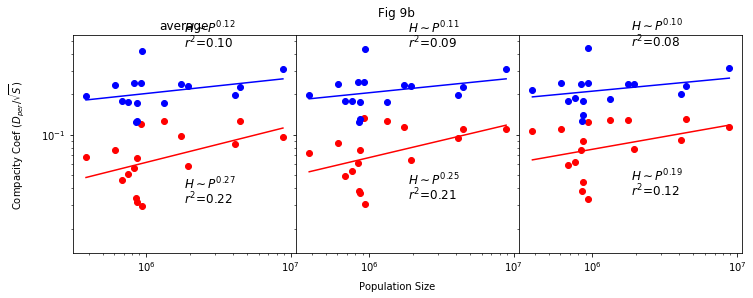

In [34]:
# graph
fig, axes = plt.subplots(1, len(gsides), figsize=(12, 4), sharex=True, sharey=True)

fig.suptitle('Fig 9b')
fig.text(0.5, 0.01, 'Population Size', ha='center', va='center')
fig.text(0.06, 0.5, r'Compacity Coef ($D_{per} / \sqrt{S}$)', ha='center', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0,wspace=0)

for i, gside in enumerate(gsides):
    for hotspot_type in ['loubar', 'average']:
        color = {'loubar': 'red', 'average': 'blue'}[hotspot_type]
        
        hstats =  pd.DataFrame(hotspot_stats_mpol[(gside, hotspot_type)])
        
        x= mex_mpol.loc[hstats.index].population
        y=hstats.compacity_coefficient
        ax = axes[i]
        ax.scatter(x, y, color=color)
        ax.set_xscale("log")
        ax.set_yscale("log")

        log_x = np.log(x)
        log_y = np.log(y)
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_x,log_y)
        min_max_x = np.array([x.min(), x.max()])
        min_max_y_fit = np.exp(slope * np.log(min_max_x) + intercept)
        log_scale_mean_x = np.exp(np.log(min_max_x).mean())
        axes[i].plot(min_max_x,min_max_y_fit, color=color)
        if i==0:
            ax.set_title(hotspot_type)

        if hotspot_type =='average':
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()*2*1.3, r'$H \sim P^{%.02f}$' % slope, ha='left', fontsize=12)
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()*2, r'$r^2 \equal {%.02f}$' % r_value**2, ha='left', fontsize=12)            
        if hotspot_type =='loubar':
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()/2, r'$H \sim P^{%.02f}$' % slope, ha='left', fontsize=12)
            axes[i].text(log_scale_mean_x, min_max_y_fit.mean()/2/1.3, r'$r^2 \equal {%.02f}$' % r_value**2, ha='left', fontsize=12)            

## Fig 15 Permenant hotspot ranking variation

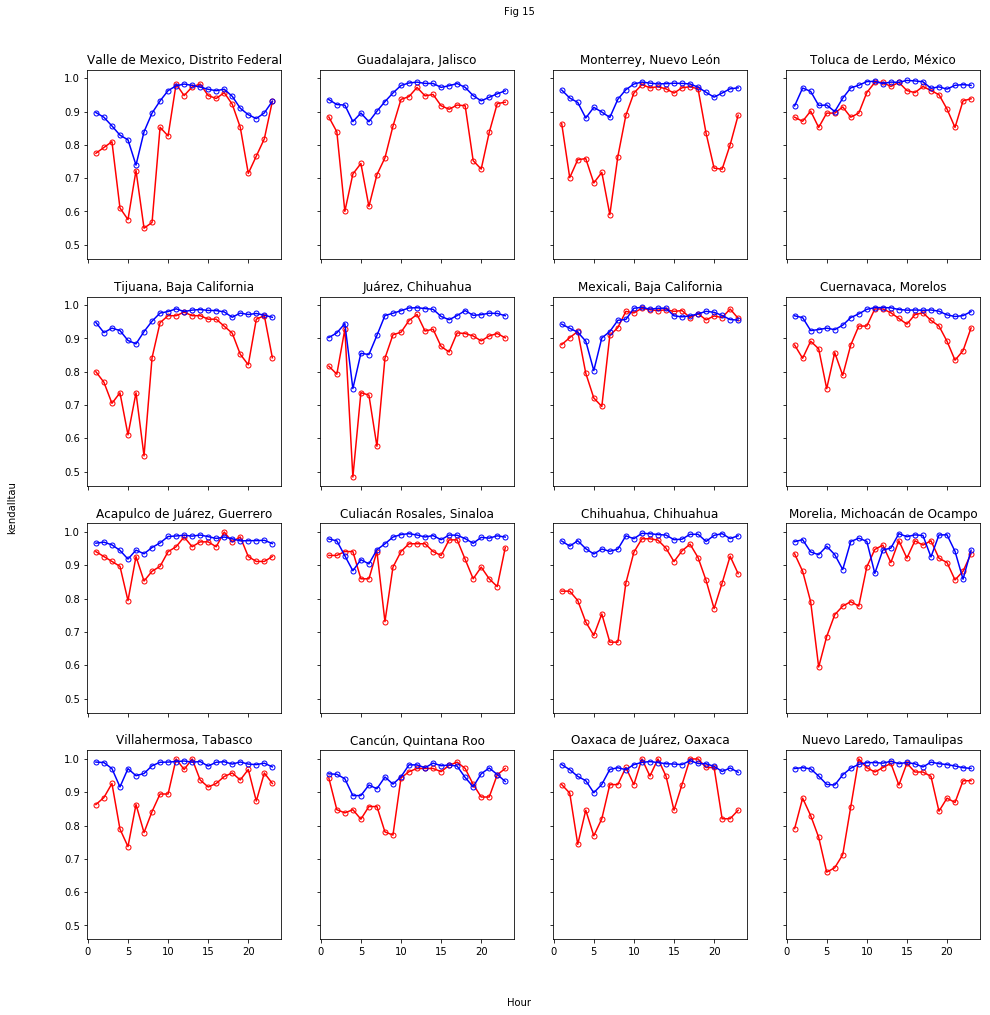

In [35]:
#
n_rows = 4
n_cols = 4
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(16, 16), sharex=True, sharey=True)

fig.text(0.5, 0.93, 'Fig 15', ha='center', va='center')
fig.text(0.5, 0.07, 'Hour', ha='center', va='center')
fig.text(0.06, 0.5, 'kendalltau', ha='center', va='center', rotation='vertical')
for htype in ['loubar', 'average']:
    color = {'loubar': 'red', 'average': 'blue'}[htype]
    regions = permanent_regions_mpol[(1000, htype)]
    for i, r in enumerate(mex_mpol.index):
        ax = axes[i // 4, i % 4]
        per_spots = regions[r]
        taus = [
            stats.kendalltau(per_spots[t1], per_spots[t2])[0]
            for t1, t2 in zip(per_spots.columns, per_spots.columns[1:])
        ]
        ax.plot(range(1, 24), taus, 'o-', color=color, markerfacecolor='None', markersize=5)
        ax.set_title(r)

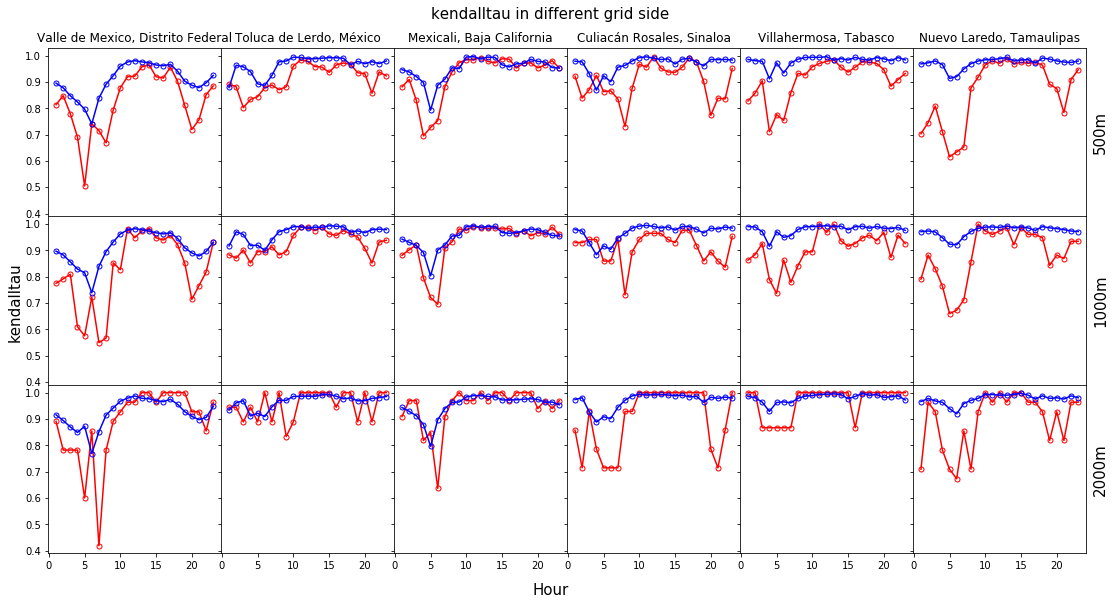

In [41]:
nth_populated_regions = [0,3,6,9,12,15]

n_rows = len(gsides)
n_cols = len(nth_populated_regions)
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(3.1*n_cols, 3.1*n_rows), sharex=True, sharey=True)

fig.text(0.5, .93, 'kendalltau in different grid side', ha='center', va='center', fontsize=15)
fig.text(0.5, 0.07, 'Hour', ha='center', va='center', fontsize=15)
fig.text(0.1, 0.5, 'kendalltau', ha='center', va='center', rotation='vertical', fontsize=15)
fig.subplots_adjust(hspace=0,wspace=0)
for i, gside in enumerate(gsides):
    for htype in ['loubar', 'average']:
        color = {'loubar': 'red', 'average': 'blue'}[htype]
        regions = permanent_regions_mpol[(gside, htype)]
        for j, r in enumerate(mex_mpol.index[nth_populated_regions]):
            ax = axes[i,j]
            per_spots = regions[r]
            taus = [
                stats.kendalltau(per_spots[t1], per_spots[t2])[0]
                for t1, t2 in zip(per_spots.columns, per_spots.columns[1:])
            ]
            ax.plot(range(1, 24), taus, 'o-', color=color, markerfacecolor='None', markersize=5)
            if i==0:
                ax.set_title(r)

                     
for i, gside in enumerate(gsides):
    ax = axes[i,n_cols-1]
    ax.text(ax.get_xlim()[1]+2, sum(ax.get_ylim())*0.5, f'{gside}m', ha='center', va='center', rotation='vertical', fontsize=15)

## Fig 10

In [19]:
import seaborn as sns

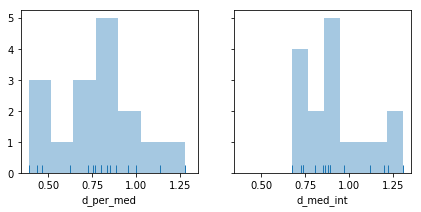

In [20]:
f, axes = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
sns.distplot(hotspot_stats_urban.d_per_med, kde=False, rug=True,bins=7, ax=axes[0])
sns.distplot(hotspot_stats_urban.d_med_int, kde=False, rug=True,bins=7, ax=axes[1])